<a href="https://colab.research.google.com/github/anuragsingh17ai/singapur-Live-trafic-vechicle-tracing/blob/main/Singapur_live_traffic_Vechicle_Counting_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Run this section to install required library/dependencies

In [1]:
!pip install beautifulsoup4 numpy opencv_python pandas plotly Requests streamlit ultralytics


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 876.6/876.6 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 6.6 MB/s eta 0:00:00


### Import Required libraries

In [4]:
import requests
from bs4 import BeautifulSoup
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import pandas as pd
import time
from datetime import datetime



model = YOLO("yolov8x.pt")


links = {
    "Woodlands": "https://onemotoring.lta.gov.sg/content/onemotoring/home/driving/traffic_information/traffic-cameras/woodlands.html#trafficCameras",
    "KJE": "https://onemotoring.lta.gov.sg/content/onemotoring/home/driving/traffic_information/traffic-cameras/kje.html#trafficCameras",
    "SLE": "https://onemotoring.lta.gov.sg/content/onemotoring/home/driving/traffic_information/traffic-cameras/sle.html#trafficCameras",
    "BKE": "https://onemotoring.lta.gov.sg/content/onemotoring/home/driving/traffic_information/traffic-cameras/bke.html#trafficCameras",
    "AYE": "https://onemotoring.lta.gov.sg/content/onemotoring/home/driving/traffic_information/traffic-cameras/aye.html#trafficCameras",
    "STG": "https://onemotoring.lta.gov.sg/content/onemotoring/home/driving/traffic_information/traffic-cameras/stg.html#trafficCameras",
    "TPE": "https://onemotoring.lta.gov.sg/content/onemotoring/home/driving/traffic_information/traffic-cameras/tpe.html#trafficCameras",
    "KPE": "https://onemotoring.lta.gov.sg/content/onemotoring/home/driving/traffic_information/traffic-cameras/kpe.html#trafficCameras",
    "CTE": "https://onemotoring.lta.gov.sg/content/onemotoring/home/driving/traffic_information/traffic-cameras/cte.html#trafficCameras",
    "MCE": "https://onemotoring.lta.gov.sg/content/onemotoring/home/driving/traffic_information/traffic-cameras/mce.html#trafficCameras",
    "ECP": "https://onemotoring.lta.gov.sg/content/onemotoring/home/driving/traffic_information/traffic-cameras/ecp.html#trafficCameras",
    "PIE": "https://onemotoring.lta.gov.sg/content/onemotoring/home/driving/traffic_information/traffic-cameras/pie.html#trafficCameras",
}


### This is going to website and for each location it is downloading images . I am using bs4 for this

In [ ]:
def fetch_camera_images(url):
    response = requests.get(url, verify=False)
    soup = BeautifulSoup(response.content, 'html.parser')
    cards = soup.find_all("div", class_="card")
    images = []
    for card in cards:
        img_tag = card.find('img')
        if img_tag:
            img_src = img_tag.get('src')
            if img_src:
                if img_src.startswith('//'):
                    img_src = "https:" + img_src
                elif img_src.startswith('/'):
                    img_src = "https://onemotoring.lta.gov.sg" + img_src
                images.append(img_src)
    return images

### This function is counting Vechicle and drawing a bb boxing around it. I have not shown these images in code because it was getting messy

In [5]:
def count_vehicles(image_url):
    try:
        response = requests.get(image_url, verify=False)
        if response.status_code != 200:
            return {'counts': {'car': 0, 'bus': 0, 'motorcycle': 0, 'truck': 0}, 'img': None}

        img = cv2.imdecode(np.frombuffer(response.content, np.uint8), cv2.IMREAD_COLOR)
        if img is None:
            return {'counts': {'car': 0, 'bus': 0, 'motorcycle': 0, 'truck': 0}, 'img': None}

        results = model.predict(img)
        vehicle_count = {'car': 0, 'bus': 0, 'motorcycle': 0, 'truck': 0}

        for result in results:
            for box in result.boxes:
                label = model.names[int(box.cls)]
                if label in vehicle_count:
                    vehicle_count[label] += 1
                    x1, y1, x2, y2 = box.xyxy[0]
                    cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
                    cv2.putText(img, label, (int(x1), int(y1) - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        _, img_encoded = cv2.imencode('.jpg', img)
        img_bytes = img_encoded.tobytes()

        return {'counts': vehicle_count, 'img': img_bytes}

    except Exception as e:
        print(f"Error fetching vehicle counts: {e}")
        return {'counts': {'car': 0, 'bus': 0, 'motorcycle': 0, 'truck': 0}, 'img': None}


### This part is basically intergrating above function and doing visualization


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'onemotoring.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 4 persons, 3 cars, 1 motorcycle, 2 traffic lights, 1 umbrella, 63.2ms
Speed: 3.3ms preprocess, 63.2ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 1 car, 3 traffic lights, 1 stop sign, 63.1ms
Speed: 3.8ms preprocess, 63.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 10 cars, 1 bus, 1 train, 1 traffic light, 1 clock, 63.1ms
Speed: 3.9ms preprocess, 63.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 4 cars, 2 trucks, 63.1ms
Speed: 3.2ms preprocess, 63.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'onemotoring.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 1 person, 1 traffic light, 63.1ms
Speed: 3.2ms preprocess, 63.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 13 cars, 1 traffic light, 63.0ms
Speed: 3.4ms preprocess, 63.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 2 persons, 5 cars, 1 motorcycle, 1 traffic light, 63.0ms
Speed: 2.4ms preprocess, 63.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 3 cars, 1 truck, 2 clocks, 63.1ms
Speed: 3.5ms preprocess, 63.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'onemotoring.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 6 cars, 2 trucks, 1 traffic light, 1 clock, 63.0ms
Speed: 2.6ms preprocess, 63.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 6 cars, 1 truck, 1 traffic light, 2 clocks, 63.0ms
Speed: 2.7ms preprocess, 63.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 11 cars, 1 truck, 63.0ms
Speed: 2.8ms preprocess, 63.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 1 car, 1 truck, 63.0ms
Speed: 3.3ms preprocess, 63.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 2 cars, 63.0ms
Speed: 2.8ms preprocess, 63.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 7 cars, 1 truck, 1 traffic light, 1 clock, 63.0ms
Speed: 2.8ms preprocess, 63.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'onemotoring.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 4 cars, 1 truck, 63.1ms
Speed: 2.9ms preprocess, 63.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 7 cars, 63.0ms
Speed: 2.7ms preprocess, 63.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 3 cars, 1 bus, 63.0ms
Speed: 2.5ms preprocess, 63.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 10 cars, 1 truck, 63.1ms
Speed: 2.6ms preprocess, 63.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 1 car, 2 trains, 2 traffic lights, 63.0ms
Speed: 2.4ms preprocess, 63.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 1 car, 63.0ms
Speed: 2.7ms preprocess, 63.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'onemotoring.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 1 person, 9 cars, 63.0ms
Speed: 2.7ms preprocess, 63.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 1 truck, 1 traffic light, 63.0ms
Speed: 2.6ms preprocess, 63.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 1 truck, 1 clock, 63.0ms
Speed: 3.6ms preprocess, 63.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 1 truck, 63.1ms
Speed: 2.9ms preprocess, 63.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 1 car, 1 bus, 63.0ms
Speed: 3.6ms preprocess, 63.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 5 cars, 1 traffic light, 1 kite, 63.1ms
Speed: 3.6ms preprocess, 63.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 3 cars, 1 truck, 1 traffic light, 63.0ms
Speed: 2.4ms preprocess, 63.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 8 cars, 1 bus, 1 truck, 63.0ms
Speed: 2.6ms preprocess, 63.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 10 cars, 1 traffic light, 63.1ms
Speed: 3.3ms preprocess, 63.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 8 cars, 1 bus, 2 trucks, 63.0ms
Speed: 2.6ms preprocess, 63.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 5 cars, 63.0ms
Speed: 3.9ms preprocess, 63.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 5 cars, 2 trucks, 1 traffic light, 63.1ms
Speed: 3.8ms preprocess, 63.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'onemotoring.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 2 cars, 5 potted plants, 63.1ms
Speed: 5.4ms preprocess, 63.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 1 train, 1 traffic light, 63.1ms
Speed: 3.8ms preprocess, 63.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'onemotoring.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 3 cars, 1 bus, 63.0ms
Speed: 2.8ms preprocess, 63.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 4 persons, 2 cars, 1 traffic light, 63.0ms
Speed: 3.1ms preprocess, 63.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 5 cars, 2 trucks, 1 traffic light, 63.0ms
Speed: 2.9ms preprocess, 63.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 6 cars, 1 bus, 1 truck, 2 traffic lights, 63.0ms
Speed: 3.8ms preprocess, 63.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 4 cars, 63.0ms
Speed: 2.6ms preprocess, 63.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 7 cars, 1 motorcycle, 1 bus, 2 trucks, 1 traffic light, 1 clock, 63.0ms
Speed: 3.2ms preprocess, 63.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 3 cars, 1 truck, 3 traffic lights, 63.0ms
Speed: 4.0ms preprocess, 63.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'onemotoring.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


0: 480x640 1 car, 76.6ms
Speed: 2.7ms preprocess, 76.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 480x640 1 car, 1 clock, 74.1ms
Speed: 2.6ms preprocess, 74.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)



/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


0: 480x640 2 cars, 74.1ms
Speed: 2.5ms preprocess, 74.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)



/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


0: 480x640 (no detections), 74.1ms
Speed: 2.8ms preprocess, 74.1ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 480x640 5 cars, 74.1ms
Speed: 2.5ms preprocess, 74.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)



/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


0: 480x640 1 truck, 1 clock, 74.1ms
Speed: 2.9ms preprocess, 74.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'onemotoring.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 4 cars, 1 bus, 1 traffic light, 63.9ms
Speed: 3.0ms preprocess, 63.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 16 cars, 1 motorcycle, 5 trucks, 2 traffic lights, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 1 person, 9 cars, 1 truck, 1 traffic light, 63.1ms
Speed: 6.1ms preprocess, 63.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 8 cars, 1 traffic light, 63.2ms
Speed: 4.9ms preprocess, 63.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 10 cars, 2 trucks, 63.1ms
Speed: 4.1ms preprocess, 63.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 19 cars, 4 traffic lights, 63.2ms
Speed: 3.4ms preprocess, 63.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 16 cars, 3 buss, 1 traffic light, 63.0ms
Speed: 2.9ms preprocess, 63.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 17 cars, 1 traffic light, 63.1ms
Speed: 3.0ms preprocess, 63.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 14 cars, 2 trucks, 2 traffic lights, 63.0ms
Speed: 2.7ms preprocess, 63.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'onemotoring.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


0: 480x640 (no detections), 75.0ms
Speed: 2.6ms preprocess, 75.0ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


0: 480x640 1 suitcase, 74.2ms
Speed: 2.6ms preprocess, 74.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)



/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


0: 480x640 1 car, 74.1ms
Speed: 2.6ms preprocess, 74.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)



/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


0: 480x640 3 cars, 1 truck, 74.9ms
Speed: 2.6ms preprocess, 74.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)



/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


0: 480x640 (no detections), 74.2ms
Speed: 2.8ms preprocess, 74.2ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'onemotoring.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 4 cars, 1 truck, 64.2ms
Speed: 3.2ms preprocess, 64.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 7 cars, 63.0ms
Speed: 3.4ms preprocess, 63.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 6 cars, 1 traffic light, 63.1ms
Speed: 3.3ms preprocess, 63.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 1 car, 63.0ms
Speed: 3.1ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 2 cars, 1 truck, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 (no detections), 63.1ms
Speed: 3.3ms preprocess, 63.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 5 cars, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 11 cars, 63.1ms
Speed: 3.2ms preprocess, 63.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'onemotoring.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 10 cars, 1 truck, 63.0ms
Speed: 3.1ms preprocess, 63.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 4 cars, 1 bench, 63.1ms
Speed: 3.3ms preprocess, 63.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 1 person, 7 cars, 1 bus, 63.1ms
Speed: 3.1ms preprocess, 63.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 6 cars, 1 truck, 1 traffic light, 63.1ms
Speed: 3.7ms preprocess, 63.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 2 cars, 63.0ms
Speed: 4.1ms preprocess, 63.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 3 cars, 63.1ms
Speed: 3.0ms preprocess, 63.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 2 persons, 16 cars, 2 buss, 1 truck, 63.1ms
Speed: 3.5ms preprocess, 63.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 5 cars, 1 truck, 63.0ms
Speed: 3.3ms preprocess, 63.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 4 cars, 1 traffic light, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 3 cars, 1 truck, 1 clock, 63.1ms
Speed: 3.0ms preprocess, 63.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 1 car, 1 truck, 1 clock, 63.1ms
Speed: 4.3ms preprocess, 63.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 1 person, 6 cars, 1 truck, 3 traffic lights, 63.1ms
Speed: 3.1ms preprocess, 63.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 10 cars, 1 bus, 2 trucks, 63.3ms
Speed: 3.3ms preprocess, 63.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 7 cars, 1 truck, 63.0ms
Speed: 3.6ms preprocess, 63.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 7 cars, 63.0ms
Speed: 5.6ms preprocess, 63.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 6 cars, 2 buss, 1 traffic light, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 4 cars, 1 bus, 1 truck, 1 traffic light, 63.0ms
Speed: 4.6ms preprocess, 63.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamall.lta.gov.sg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



0: 384x640 8 cars, 2 traffic lights, 63.1ms
Speed: 3.9ms preprocess, 63.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


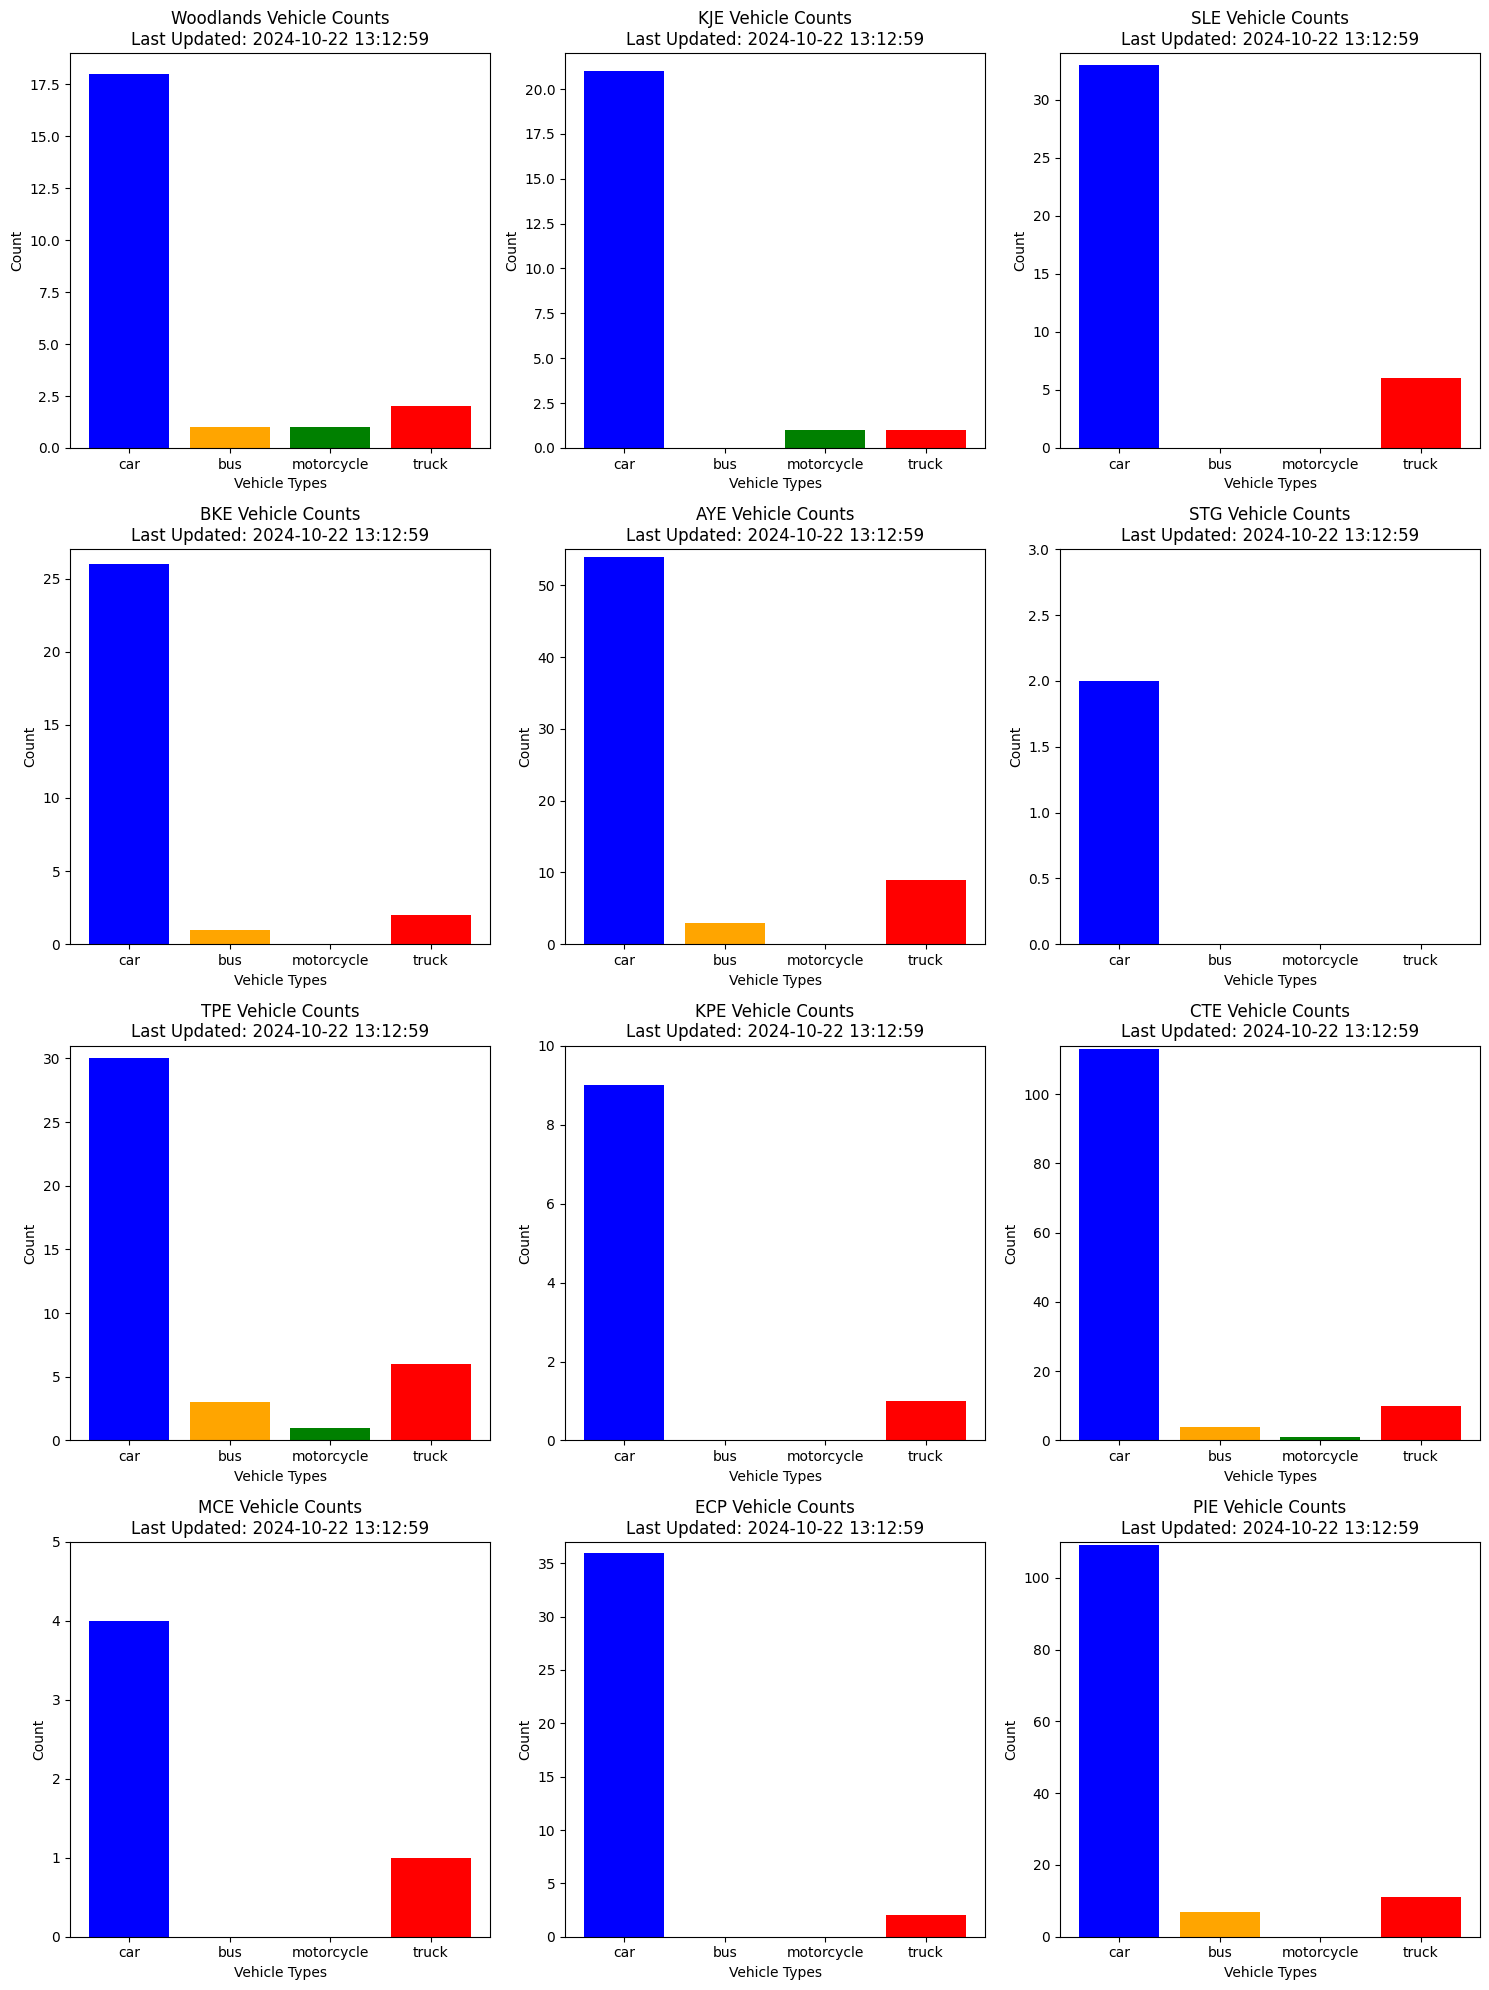

In [9]:
def main():
    traffic_data = {location: [] for location in links.keys()}
    start_monitoring = True  # Change this to control monitoring

    if start_monitoring:
        for location, link in links.items():
            image_urls = fetch_camera_images(link)
            total_counts = {'car': 0, 'bus': 0, 'motorcycle': 0, 'truck': 0}

            for img_url in image_urls:
                result = count_vehicles(img_url)
                counts = result['counts']

                for vehicle_type in total_counts.keys():
                    total_counts[vehicle_type] += counts.get(vehicle_type, 0)

            traffic_data[location].append(total_counts)


        n_locations = len(traffic_data)
        n_cols = 3
        n_rows = (n_locations + n_cols - 1) // n_cols

        fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
        axs = axs.flatten()

        for i, location in enumerate(links.keys()):
            if traffic_data[location]:
                counts = traffic_data[location][-1]
                timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

                axs[i].bar(counts.keys(), counts.values(), color=['blue', 'orange', 'green', 'red'])
                axs[i].set_title(f"{location} Vehicle Counts\nLast Updated: {timestamp}")
                axs[i].set_xlabel("Vehicle Types")
                axs[i].set_ylabel("Count")
                axs[i].set_ylim(0, max(counts.values()) + 1)


        for j in range(i + 1, len(axs)):
            axs[j].axis('off')


        plt.subplots_adjust(hspace=0.6, wspace=0.4)
        plt.tight_layout()
        plt.show()
main()